### Sparkify Project understanding:

- This project is part of my Udacity Data Scientist Nanodegree Capstone project.

- The aim of this project is to train a classification algorithm to predict users which may get churned in near future based on the information and variables available in user log data. More specifically, this data relates to a fictitious music streaming service called Sparkify which contains several informative variables such as:

 |-- artist
 |-- auth
 |-- firstName
 |-- gender
 |-- itemInSession
 |-- lastName
 |-- length
 |-- level
 |-- location
 |-- method 
 |-- page
 |-- registration
 |-- sessionId
 |-- song
 |-- status
 |-- ts
 |-- userAgent
 |-- userId

### Process Overview:

- To run the analysis locally on my machine, I've based my analysis & modeling exercise on a smaller subset (128 MB) of the full dataset(12 GB). I chose not to change this part for the AWS EMR version of this notebook.

- Reason behind taking Smaller version of dataset is due to the fact that it is small enough to fit into the memory of a local machine in comparison to the full dataset which will likely to cause issues due to its large size. To deal with this size of data, it is necessary to make use of distributed computing. 

- As the name of the fictitious streaming service "Sparkify" already implies, this project uses Spark, more specifically **The Python API PySpark** to deal with the large dataset. **PySpark** as a high-level API allows us to focus on working with the data without having to dive too deep into the principles of distributed computing.

### Analysis Structure:

- The project starts off with loading the data, dropping cases where there were no user IDs and initial investigation of the data.

- Following this, the target variable (whether a user has churned or not) is defined and several features at user level are created. This is an important point because while the original log data contains many rows for each individual user, in order to perform binary classification we will need to have only one row for each user.

- These features are then compared across the two user groups, i.e. those who have churned and those who have not, to identify features which may help in predicting users' behaviour.

- A new dataframe containing only the relevant features and the labels (using the tiny dataset or the full one depending upon the notebook chosen) is then created. Before the data is split into a train and a test set, outliers of numerical features are removed, numerical features are scaled using min-max scaling and categorical features are encoded using one-hot encoding.

- The training and test datasets are then used to compare a logistic regression, random forest classifier and gradient-boosted tree classifier. The models are evaluated using the F1 score to account for the imbalanced nature of the dataset (i.e. there are only few users who have actually churned) and accuracy rate.

- The best model is then chosen and optimised by using hyperparameter tuning. Finally, the results of the optimised model are briefly discussed.

- Below I'll walk through the entire process which I've taken to complete this project. 

#### Step:1- Calling necessary libraries which will be used in this project

In this step, I'll call all the required libraries which I'll use in this project for data reading, cleaing,exploring, modeling & testing.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import datetime
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, col, concat, desc, explode, lit, min, max, split, udf, isnull
from pyspark.sql import functions as sF
from pyspark.sql.types import IntegerType
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, DecisionTreeClassifier, NaiveBayes, LinearSVC
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, PCA, RegexTokenizer, StandardScaler, StopWordsRemover, StringIndexer, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.sql import Window

from pyspark.sql.functions import lag as Flag
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.functions import when as Fwhen
from pyspark.sql.functions import isnull as Fisnull
from pyspark.sql.functions import isnan, when, count, col, isnull, udf, last, first, struct, lit, approx_count_distinct

%matplotlib inline

#### Step:2 - create a Spark session and load the data

As mentioned above, this project uses Spark, more specifically **The Python API PySpark** to deal with the large dataset. **PySpark** as a high-level API allows us to focus on working with the data without having to dive too deep into the principles of distributed computing, I'll create a Spark session to work on the data in this enviournment.

In [2]:
spark = SparkSession.builder.appName("Sparkify").getOrCreate()

In [3]:
sparkify_data = 'mini_sparkify_event_data.json'
df = spark.read.json(sparkify_data)
# See the frame schema
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)




- Looking at the schema, we can observe that there is a total of 18 columns of which 12 are strings. Even out of those variables that are not strings only length really seems to be a classical numerical variable. One could perhaps also include the timestamp ("ts"), but as a date it should be dealt with differently than a quantitative variable. As for the other variables that are not integers, they really just represent some sort of ID and can therefore not be interpreted as numbers.

- So, overall it seems as though we are dealing with mainly categorical variables. This will have certain implications later on once we deal with feature engineering.

- Let us also briefly note that there are some columns such as a user's first name where it is almost immediately obvious that they will most likely not help us with predicting user churn rates. We may thus be able to drop some columns later on.

#### Step:3 - initial Data Cleaning and Analysis

Now, In this step I'll take a look about the data such as #of total observations, #of missing IDs, #of duplicates etc. and fix it so that we can get a more structured and refined data for modeling purpose.

In [4]:
# Tabulated head through pandas
df1 = df.toPandas()
df1.head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30


In [5]:
# To know nulls
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286500 entries, 0 to 286499
Data columns (total 18 columns):
artist           228108 non-null object
auth             286500 non-null object
firstName        278154 non-null object
gender           278154 non-null object
itemInSession    286500 non-null int64
lastName         278154 non-null object
length           228108 non-null float64
level            286500 non-null object
location         278154 non-null object
method           286500 non-null object
page             286500 non-null object
registration     278154 non-null float64
sessionId        286500 non-null int64
song             228108 non-null object
status           286500 non-null int64
ts               286500 non-null int64
userAgent        278154 non-null object
userId           286500 non-null object
dtypes: float64(2), int64(4), object(12)
memory usage: 39.3+ MB


We can see that variables such as artist, length, song has null values present.

In [6]:
# checking the values of some categoric columns

df1.level.unique(),df1.method.unique(),df1.page.unique(),df1.status.unique(),df1.gender.unique(),df1.auth.unique()

(array(['paid', 'free'], dtype=object),
 array(['PUT', 'GET'], dtype=object),
 array(['NextSong', 'Add to Playlist', 'Roll Advert', 'Thumbs Up',
        'Downgrade', 'Thumbs Down', 'Home', 'Logout', 'Help', 'Login',
        'Upgrade', 'Add Friend', 'About', 'Settings', 'Submit Upgrade',
        'Submit Downgrade', 'Error', 'Save Settings', 'Cancel',
        'Cancellation Confirmation', 'Register', 'Submit Registration'], dtype=object),
 array([200, 307, 404]),
 array(['M', 'F', None], dtype=object),
 array(['Logged In', 'Logged Out', 'Cancelled', 'Guest'], dtype=object))

In [7]:
#Checking for missing user id in Spark
df.filter(df.userId == '').count()

8346

It turns out that there are 8346 rows of unregistered users (the "userId" column is empty and there is no personal user information, i.e. first/ last name and gender available. As for the former, it seems reasonable to simply drop these rows since we only care about the churn of existing users.

In [8]:
# Dropping the missing User's ID rows
df = df.filter(df.userId != '')

In [9]:
df.filter(df.userId == '').count()

0

In [10]:
# Removing duplicate UserID
df.select("userId").dropDuplicates().count()

225

In [11]:
# Removing duplicates in Session ID
df.select("sessionId").dropDuplicates().count()

2312

In [12]:
# Checking the structure of some features
df.select("page").distinct().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



In [13]:
# Let's check users who did "Cancellation Confirmation"
df.select("artist").distinct().show()

+--------------------+
|              artist|
+--------------------+
|      The Black Keys|
|         Silverstein|
|           Kate Nash|
|        Yann Tiersen|
|    Jane's Addiction|
|          Tim Hughes|
|          Carl Craig|
|Dashboard Confess...|
|Yonder Mountain S...|
|           Los Lobos|
|Pete Rock & C.L. ...|
|        Ziggy Marley|
|      Jarabe De Palo|
|               Rufio|
|WC And The Maad C...|
|      Jorge Gonzalez|
|                Silk|
|  The Watts Prophets|
|            La Shica|
|        Generation X|
+--------------------+
only showing top 20 rows



In [14]:
# Clean the NA value in userId and sessionId
df = df.dropna(how = "any", subset = ["userId", "sessionId"])
df.count()

278154

#### Step:4- Exploratory Data Analysis

Now, We'll take a look in depth about the data points available in this dataset and which will be the most useful variables we can use for feature engg.

In [15]:
# Number of Observations and Distribution of Number of Interactions

# Explore dimensions after dropping NANs
num_obs = df.count()
num_cols = len(df.columns)
print('Number of observations: {}'.format(num_obs))
print('Number of columns:{}'.format(num_cols))

# Have a look at the number of unique user IDs and the average number of interactions per user ID
num_users = df.select('userId').dropDuplicates().count()
print('Number of unique users: {}'.format(num_users))
print('Average number of interactions per user {}'.format(num_obs/num_users))

Number of observations: 278154
Number of columns:18
Number of unique users: 225
Average number of interactions per user 1236.24


- It turns out that what initially seemed like a rather larger data set is not that large because there were on average about 1236 interactions per user. Hence, the 278,154 interactions represent really just data of 225 unique users.

- Our goal is to use the log data to predict churn rates of individual users. Hence, we will ultimately need to aggregate the user log data at the user ID level to be able predict churn rates when we turn towards feature engineering and prediction. In this sense, we should probably think of the number of unique users as being more representative of our sample size.

- Even so, it is also true that the more interactions we have recorded for each user the better we should be able to predict whether they will churn or not.

- Next, let us have a brief look at how the number of interactions is distributed across the 225 unique users.

Median number of interactions per user: 848.0
Standard deviation of interactions per user: 1329.531716432519
Minimum number of interactions for a single user: 6
Maximum number of interactions for a single user: 9632


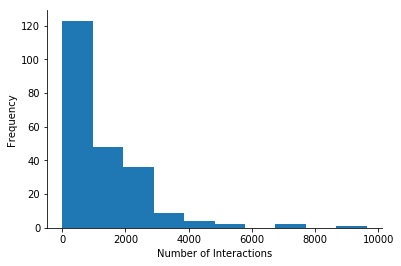

In [16]:
# Create a pandas dataframe with the distribution of the number of interactions and plot it

interactions_df = df.groupBy('userId').count().toPandas()
interactions_df.plot.hist(sns.color_palette()[0], legend = None)
plt.xlabel('Number of Interactions')
sns.set(style="ticks")
sns.despine(right=True,top=True)
plt.savefig('sparkify_num_interactions.png', dpi = 300)
print('Median number of interactions per user: {}'.format(interactions_df['count'].median()))
print('Standard deviation of interactions per user: {}'.format(interactions_df['count'].std()))
print('Minimum number of interactions for a single user: {}'.format(interactions_df['count'].min()))
print('Maximum number of interactions for a single user: {}'.format(interactions_df['count'].max()))

- We can see that there is quite a lot of variability with respect to the number of interactions per user. This was probably to be expected. There will usually be some users who won't use a service too much while others may actually be power users. 

- As long as we have at least some interactions for each user and as long as this difference in usage intensity is later on somehow reflected in our features, we will probably be fine.

**Checking Distribution of Dates:**

Here I'm looking at ratio of users who have churned differ from those who have not with respect to the distribution of dates in the data. To simplify things, I decided to simply look at year and month.

In [17]:
# Convert timestamps to year-month and save this in a new column 
get_time = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime('%Y-%m'))
df = df.withColumn("time", get_time(df.ts))

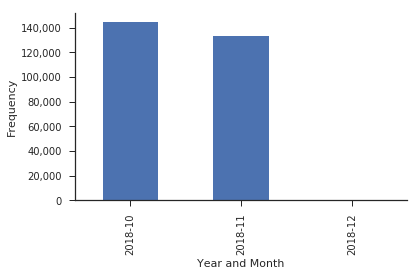

In [18]:
# Obtain pandas dataframe containing counts of year-month combinations and plot the result

year_month_df = df.groupBy('time').count().toPandas()
ax = year_month_df.plot.bar(x = 'time', legend = None)
sns.set(style="ticks")
sns.despine(right=True,top=True)
plt.xlabel('Year and Month')
plt.ylabel('Frequency')

# add commas to y-axis labels
ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])
plt.tight_layout()
# Save figure as file
plt.savefig('sparkify_year_month_distribution.png', dpi = 300)

- It turns out that the Sparkify log data consists essentially of data collected in October 2018 and November 2018 in almost equal proportions.

- In general, the more data we have the better, but overall user behaviour and preferences may change over time. Hence, if we were to use data collected over e.g. 5 years we would probably need to somehow account for these changes. In addition to this, changes in the service itself such as a new UI or changes in the content available may also cause data not to be comparable anymore. In fact, such changes could be the very reason for users to churn.

- On the other hand, if the time period covered by our data is too short, this may also have a detrimental effect on the predictive power of our model. With this small dataset covering mostly only two months' worth of data, it could very well be possible that a lot of users only become tired of the service after three months or perhaps half a year.

- Ultimately, while the data for this project was provided, in real life it could probably be rather important to think about how long the time period covered by the data should be.

In [19]:
# Extracting Location information from data

get_location=udf(lambda x:x[-2:])
df = df.withColumn("location_state", get_location(df.location))

In [20]:
df.select("location_state").distinct().show()

+--------------+
|location_state|
+--------------+
|            AZ|
|            SC|
|            LA|
|            NJ|
|            OR|
|            VA|
|            KY|
|            NH|
|            MI|
|            NV|
|            WI|
|            ID|
|            CA|
|            CT|
|            MT|
|            NC|
|            MD|
|            MO|
|            IL|
|            WA|
+--------------+
only showing top 20 rows



**Defining Churn:**

**Definition:** A narrow definition would probably only include people who have deleted their account which is captured in our data as cases where the page feature takes on the value "Cancellation Confirmation". We can also define users as churn who are switching from the paid subscriptions to the free service. 

It turns out that identifying these users is a bit more complicated. While a user can only cancel their registration once, it is very much possible for a customer to downgrade from the paid to the free service and to then upgrade to the paid service again or to even repeat this cycle which this data doesn't tell.

It therefore seemed justifiable to me to only look at users who completely stopped using the service. So, below I'm defining the churn and then will explore the data like dropping duplicates, getting gender wise stats etc.

In [21]:
# Churn is a label for user who cancelled

# Define a flag function
churn_users = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())

# apply to the dataframe
df = df.withColumn("churn", churn_users("page"))

#Define window bounds
windowval = Window.partitionBy("userId").rangeBetween(Window.unboundedPreceding, Window.unboundedFollowing)

# Applying the window
df_withchurn = df.withColumn("churn", Fsum("churn").over(windowval))

In [22]:
#Drop duplicates in userId in spark
df_withchurn.dropDuplicates(['userId']).groupby(['churn']).count().show()

+-----+-----+
|churn|count|
+-----+-----+
|    0|  173|
|    1|   52|
+-----+-----+



In [23]:
#Drop duplicates user status by gender in Spark
df_withchurn.dropDuplicates(['userId', 'gender']).groupby(['churn', 'gender']).count().show()

+-----+------+-----+
|churn|gender|count|
+-----+------+-----+
|    0|     F|   84|
|    1|     M|   32|
|    1|     F|   20|
|    0|     M|   89|
+-----+------+-----+



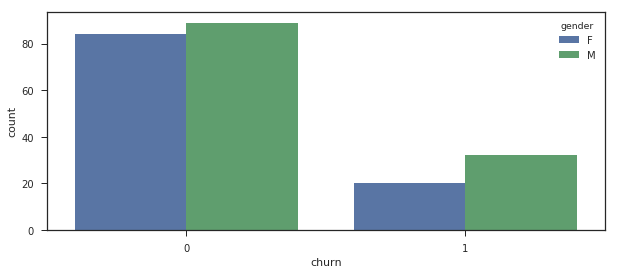

In [24]:
#Plotting Gender wise churn statistics in a graph

plt.figure(figsize=(10, 4))
df_pd = df_withchurn.dropDuplicates(["userId", "gender"]).groupby(["churn", "gender"]).count().sort("churn").toPandas()
sns.barplot(x='churn', y='count', hue='gender', data=df_pd);

In [25]:
# Have a look at how many users have churned and how many have not

print('Number of users who have churned {}'.\
      format(df_withchurn.filter(df_withchurn.churn == 1).select('userId').dropDuplicates().count()))
print('Number of users who have not churned {}'.\
      format(df_withchurn.filter(df_withchurn.churn == 0).select('userId').dropDuplicates().count()))

Number of users who have churned 52
Number of users who have not churned 173


**Comparing Users Who Churned and Those Who Did Not:**

Now that we have defined churn and identified those users who churned, we should have a look at some features and how their distribution differs across the two groups of users: those who have churned and those who have not.

**I've decided to look at the following aggregated metrics:**

1. Customer lifetime statistics
2. Number of songs per session
3. Number of songs per session (Gender wise Split)
4. Page wise distribution between churn user and normal user
5. Churn stats by User level
6. Churn pattern based on location of the users
7. Total Number of Sessions for Each User
8. Calculating Unique Number of Artists
9. Getting Total songs per user
10. avg & min & max time per session
11. How many artists have the user heard

In the following cells these measures are calculated and where necessary some additional explanations were added.

In [26]:
#1. Customer lifetime statistics
lifetime_pd = df_withchurn.where('page == "NextSong" OR page == "Thumbs Up"').groupby(['userId', 'churn', 'gender', 'page']).count().toPandas()
lifetime_pd = lifetime_pd.pivot_table(index=['userId','churn','gender'], values='count', columns='page').reset_index()

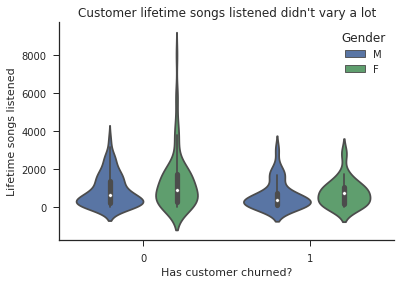

In [27]:
ax = sns.violinplot(data=lifetime_pd, x='churn', y='NextSong', hue='gender')
plt.xlabel('Has customer churned?')
plt.ylabel('Lifetime songs listened')
plt.legend(title='Gender', loc='best')
plt.title('Customer lifetime songs listened didn\'t vary a lot')
sns.despine(ax=ax);

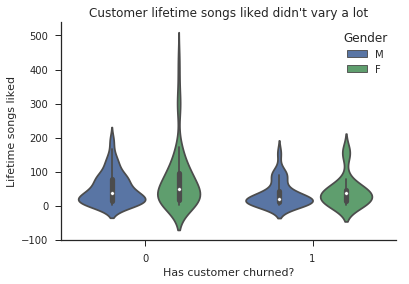

In [28]:
ax = sns.violinplot(data=lifetime_pd, x='churn', y='Thumbs Up', hue='gender')
plt.xlabel('Has customer churned?')
plt.ylabel('Lifetime songs liked')
plt.legend(title='Gender', loc='best')
plt.title('Customer lifetime songs liked didn\'t vary a lot')
sns.despine(ax=ax);

In [40]:
#2. Number of songs per session

user_session_songs = df_withchurn.filter(df_withchurn.page=="NextSong").groupby("userId", "sessionId").count()
user_session_songs_avg = user_session_songs.groupby("userId").agg(avg(user_session_songs["count"]).alias("avgSessionSongs")).sort("userId")
user_session_songs_avg.show(5)

+------+------------------+
|userId|   avgSessionSongs|
+------+------------------+
|    10|112.16666666666667|
|   100| 78.88235294117646|
|100001|             33.25|
|100002|             48.75|
|100003|              25.5|
+------+------------------+
only showing top 5 rows



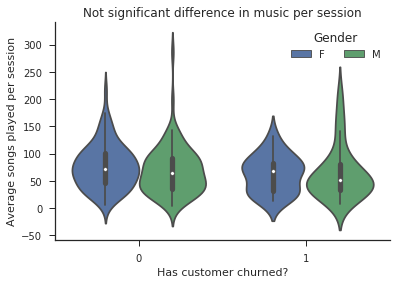

In [41]:
#3. Number of songs per session (Gender wise Split)

songs_gender_pd = df_withchurn.where('page == "NextSong"').groupby(['churn', 'userId', 'sessionId','gender']).count()\
    .groupby(['churn', 'userId', 'gender']).agg({'count':'avg'})\
    .withColumnRenamed('avg(count)', 'avg_songs_played')\
    .toPandas()

ax = sns.violinplot('churn', y='avg_songs_played', hue='gender', data=songs_gender_pd)
plt.xlabel('Has customer churned?')
plt.ylabel('Average songs played per session')
plt.legend(title='Gender', loc='best', ncol=2)
plt.title('Not significant difference in music per session')
sns.despine(ax=ax);

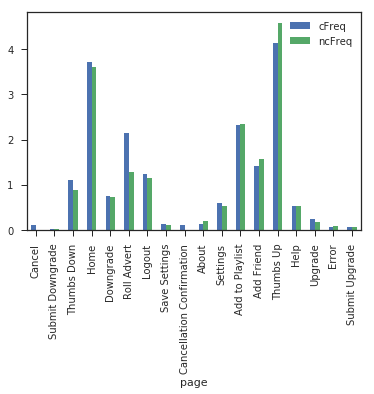

In [30]:
#4. Page wise distribution between churn user and normal user

churn_count = df_withchurn.filter(df_withchurn.churn==1).count()
no_churn_count = df_withchurn.filter(df_withchurn.churn==0).count()

df_temp1 = df_withchurn.filter(df_withchurn.churn==1).filter(df_withchurn.page!="NextSong").groupby(["page"]).count()
df_temp1 = df_temp1.withColumn("cFreq", df_temp1["count"]/(churn_count/100)).sort("page")

df_temp2 = df_withchurn.filter(df_withchurn.churn==0).filter(df_withchurn.page!="NextSong").groupby(["page"]).count()
df_temp2 = df_temp2.withColumn("ncFreq", df_temp2["count"]/(no_churn_count/100)).sort("page")

plt.figure(figsize=(14, 6))
df_pd = df_temp1.join(df_temp2, "page", "outer").drop("count").fillna(0).toPandas()
df_pd.plot.bar("page");

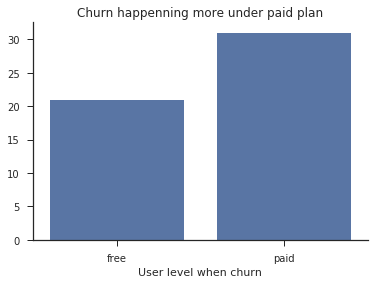

In [31]:
#5. Churn stats by User level

level_pd = df_withchurn.filter('page == "Cancellation Confirmation"').groupby('level').count().toPandas()

ax = sns.barplot(data=level_pd, x='level', y='count', color=sns.color_palette()[0])
plt.xlabel('User level when churn')
plt.ylabel('')
plt.title('Churn happenning more under paid plan')
sns.despine(ax=ax);

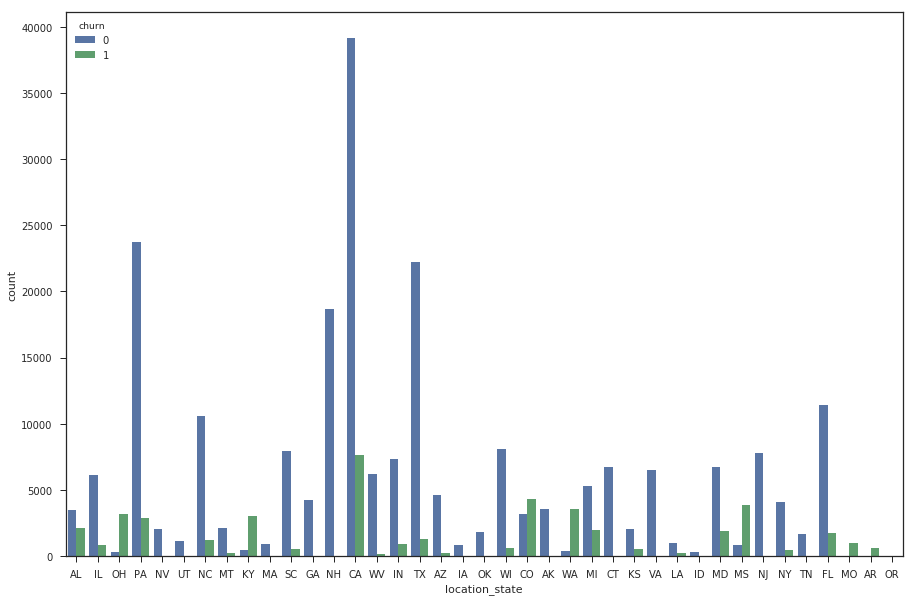

In [32]:
#6. Churn pattern based on location of the users

plt.figure(figsize=(15,10))
df_location=df_withchurn.groupby(["location_state", "churn"]).count().sort("churn").toPandas()
sns.barplot(x='location_state', y='count', hue='churn', data=df_location);

**Churn pattern based on location of the users:**

Depending on the location, users' preferences or their economic situation may differ. Hence, the location could also be an interesting feature to investigate. Since this is a categorical variable, we will ultimately, should we indeed use this feature, by using e.g. one-hot encoding need about as many columns as there are different locations. 
As it was included in this data, the location column contains both a user's city and the state they live in. To simlify this problem, let us just have a look at the state.

I found that, Clifornia state has most numbers of Non Churn users present followed by Pennsylvania, Texas & New Hampshire.Further although churn ratio is also higher for CA when compared to other ones but if we see state wise distribution b/w both user types, it is not in similar ration & differs location wise. Also, Some states has less churned users compared to others.

In [33]:
#7. Total Number of Sessions for Each User

prev_val_window = Window.partitionBy('userId').orderBy('ts')
df_withchurn = df_withchurn.withColumn('sessionId_prev',Flag(df_withchurn.sessionId).over(prev_val_window))


# create column 'new_session' (0 or 1)
new_session = udf(lambda session_ids: 1 if (session_ids[0] != session_ids[1]) & (session_ids[0] is not None) else 0, 
                  IntegerType())
# Create column indicating whether the session ID is new and also set it to 1 for the first session ID for
# each user which is the only case where the previous session ID column will have a value of null
df_withchurn = df_withchurn.withColumn('new_session',Fwhen(Fisnull(df_withchurn.sessionId_prev), 1).\
                                                      otherwise(new_session(struct('sessionId_prev','sessionId'))))

# Obtain total number of sessions for each user
df_withchurn = df_withchurn.withColumn('sessions_num', Fsum('new_session').over(windowval))
df_withchurn.head()

# Credit: https://www.arundhaj.com/blog/calculate-difference-with-previous-row-in-pyspark.html

Row(artist='Sleeping With Sirens', auth='Logged In', firstName='Darianna', gender='F', itemInSession=0, lastName='Carpenter', length=202.97098, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='NextSong', registration=1538016340000, sessionId=31, song='Captain Tyin Knots VS Mr Walkway (No Way)', status=200, ts=1539003534000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', time='2018-10', location_state='CT', churn=0, sessionId_prev=None, new_session=1, sessions_num=7)

**Total Number of Sessions for Each User:**

As the first step,I've considered total number of sessions for each user. It turns out that we cannot use the approx_count_distinct PySpark SQL function here.

So, I've followed the following approach:

- Using a window function obtain the previous sessionId for each user's previous row
- Create a column indicating whether the session ID changed (we need to have it also display a 1 for the very first row)
- Take the sum of "new_session" column to obtain the total number of sessions

In [37]:
#8. Calculating Unique Number of Artists

# In this case we can use approx_count_distinct function to obtain the number of unique artists a user listened to.

df_withchurn = df_withchurn.withColumn('dist_num_artists', approx_count_distinct('artist').over(windowval))
df_withchurn.head()

Row(artist='Sleeping With Sirens', auth='Logged In', firstName='Darianna', gender='F', itemInSession=0, lastName='Carpenter', length=202.97098, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='NextSong', registration=1538016340000, sessionId=31, song='Captain Tyin Knots VS Mr Walkway (No Way)', status=200, ts=1539003534000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', time='2018-10', location_state='CT', churn=0, sessionId_prev=None, new_session=1, sessions_num=7, dist_num_artists=249)

In [36]:
#9. Getting Total songs per user

song_per_user = df_withchurn\
                  .select("userId","song")\
                  .groupby("userId")\
                  .count()\
                  .withColumnRenamed("count","song_per_user")
song_per_user.show(50)

+------+-------------+
|userId|song_per_user|
+------+-------------+
|100010|          381|
|200002|          474|
|   125|           11|
|    51|         2464|
|   124|         4825|
|     7|          201|
|    54|         3437|
|    15|         2278|
|   155|         1002|
|   132|         2304|
|   154|          118|
|100014|          310|
|   101|         2149|
|    11|          848|
|   138|         2469|
|300017|         4428|
|    29|         3603|
|    69|         1342|
|100021|          319|
|    42|         4257|
|   112|          292|
|    87|         1003|
|    73|          457|
|    64|           68|
|200010|          317|
|     3|          254|
|    30|         1775|
|   113|         1895|
|    34|           73|
|   133|           44|
|    59|          872|
|   146|          837|
|   139|          457|
|     8|          334|
|    28|         1781|
|    22|           40|
|300018|         2046|
|300012|          786|
|100022|          964|
|    85|         4370|
|    52|   

**Getting Total songs per user:**

We can also have a look at for how long each user has been using the service. Total song per user calculation is pretty simple. I've just grouped songs based on userIDs and then renamed the output to "songs per user"

In [38]:
#10. avg & min & max time per session

user_session_time = df_withchurn.groupby("userId", "sessionId").agg(((max(df_withchurn.ts)-min(df_withchurn.ts))/(1000*60)).alias("sessionTime"))
user_session_time_stat = user_session_time.groupby("userId").agg(avg(user_session_time.sessionTime).alias("avgSessionTime"), min(user_session_time.sessionTime).alias("minSessionTime"), max(user_session_time.sessionTime).alias("maxSessionTime")).sort("userId")
user_session_time_stat.show(5)

+------+------------------+-----------------+------------------+
|userId|    avgSessionTime|   minSessionTime|    maxSessionTime|
+------+------------------+-----------------+------------------+
|    10|459.74722222222226|91.41666666666667|1547.9166666666667|
|   100| 316.5190476190476|              0.0|1019.5833333333334|
|100001|148.15833333333333|             63.0|215.28333333333333|
|100002|201.18333333333334|              0.0| 730.4666666666667|
|100003| 99.11666666666667|3.216666666666667|195.01666666666668|
+------+------------------+-----------------+------------------+
only showing top 5 rows



**avg & min & max time per session:**

I've calculated the average lenght of a user's sessions by summing up the differences between the timestamps recorded during a session and dividing them by the number of total sessions. 

Note that we need to ignore the difference between the last timestamp of one session and the first timestamp of the next session in order not to count users' inactivity as activity.

In [43]:
#11. How many artists have the user heard

user_artist_count = df_withchurn.filter(df_withchurn.page=="NextSong").select("userId", "artist").dropDuplicates().groupby("userId").count()
user_artist_count = user_artist_count.withColumnRenamed("count", "aritstCount")
user_artist_count.show(5)

+------+-----------+
|userId|aritstCount|
+------+-----------+
|100010|        252|
|200002|        339|
|   125|          8|
|    51|       1385|
|   124|       2232|
+------+-----------+
only showing top 5 rows



### Step:5- Feature Engineering

Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.

    1.Write a script to extract the necessary features from the smaller subset of data
    2.Ensure that your script is scalable, using the best practices discussed in Lesson 3
    3.Try your script on the full data set, debugging your script if necessary

By looking at the above analysis,I've identified some features which may be interesting for my machine learning model(first values in parentheses refer to churners while the second refer to non-churners). 

These features are:

Feature 1: number of days since registration
Feature 2: Total songs per user
Feature 3: Gender wise distribution
Feature 4: Listening Time per user
Feature 5: avg & min & max time per session
Feature 6: number of sessions
Feature 7: Number of songs per session
Feature 8: session duration
Feature 9: Type of user (Paid:1 or Free:0)
Feature 10: how many artists have the user heard

Below, I've processed these features one by one for modeling purpose. 

In [44]:
# Feature 1: number of days since registration
user_max_ts = df_withchurn.groupby("userId").max("ts").sort("userId")
user_reg_ts = df_withchurn.select("userId", "registration").dropDuplicates().sort("userId")
user_reg_days = user_reg_ts.join(user_max_ts, user_reg_ts.userId == user_max_ts.userId).select(user_reg_ts["userId"], ((user_max_ts["max(ts)"]-user_reg_ts["registration"])/(1000*60*60*24)).alias("regDay"))
user_reg_days.show(5)

+------+------------------+
|userId|            regDay|
+------+------------------+
|100010| 55.64365740740741|
|200002| 70.07462962962963|
|   125| 71.31688657407408|
|   124|131.55591435185184|
|    51|19.455844907407407|
+------+------------------+
only showing top 5 rows



In [45]:
# Feature 2: Total songs per user
song_per_user = df_withchurn\
                  .select("userId","song")\
                  .groupby("userId")\
                  .count()\
                  .withColumnRenamed("count","song_per_user")
song_per_user.show(10)

+------+-------------+
|userId|song_per_user|
+------+-------------+
|100010|          381|
|200002|          474|
|   125|           11|
|    51|         2464|
|   124|         4825|
|     7|          201|
|    54|         3437|
|    15|         2278|
|   155|         1002|
|   132|         2304|
+------+-------------+
only showing top 10 rows



In [46]:
# Feature 3: Gender wise distribution

gender = df_withchurn\
         .select('userId','gender')\
         .replace(['M','F'],['0','1'],'gender')\
         .select('userId',col('gender').cast('int'))\
         #.withColumnRenamed('gender', 'gender_num') 
gender.show(20)

+------+------+
|userId|gender|
+------+------+
|    30|     0|
|     9|     0|
|    30|     0|
|     9|     0|
|    30|     0|
|     9|     0|
|     9|     0|
|    30|     0|
|    30|     0|
|    30|     0|
|     9|     0|
|     9|     0|
|    30|     0|
|     9|     0|
|     9|     0|
|    30|     0|
|     9|     0|
|    74|     1|
|    30|     0|
|     9|     0|
+------+------+
only showing top 20 rows



In [47]:
# Feature 4: Listening Time per user

listening_time = df_withchurn\
            .select('userId','length')\
            .groupby(['userId'])\
            .sum()\
            .withColumnRenamed('sum(length)','listening_time')

listening_time.show(10)

+------+------------------+
|userId|    listening_time|
+------+------------------+
|100010| 66940.89735000003|
|200002| 94008.87593999993|
|   125|2089.1131000000005|
|    51| 523275.8428000004|
|   124|1012312.0927899999|
|     7| 38034.08710000002|
|    54| 711344.9195400011|
|    15|477307.60581000015|
|   155|       198779.2919|
|   132| 483118.9038399997|
+------+------------------+
only showing top 10 rows



In [48]:
#Feature 5: avg & min & max time per session
user_session_time = df_withchurn.groupby("userId", "sessionId").agg(((max(df_withchurn.ts)-min(df_withchurn.ts))/(1000*60)).alias("sessionTime"))
user_session_time_stat = user_session_time.groupby("userId").agg(avg(user_session_time.sessionTime).alias("avgSessionTime"), min(user_session_time.sessionTime).alias("minSessionTime"), max(user_session_time.sessionTime).alias("maxSessionTime")).sort("userId")
user_session_time_stat.show(5)

+------+------------------+-----------------+------------------+
|userId|    avgSessionTime|   minSessionTime|    maxSessionTime|
+------+------------------+-----------------+------------------+
|    10|459.74722222222226|91.41666666666667|1547.9166666666667|
|   100| 316.5190476190476|              0.0|1019.5833333333334|
|100001|148.15833333333333|             63.0|215.28333333333333|
|100002|201.18333333333334|              0.0| 730.4666666666667|
|100003| 99.11666666666667|3.216666666666667|195.01666666666668|
+------+------------------+-----------------+------------------+
only showing top 5 rows



In [49]:
# Feature 6: number of sessions
user_session_count = df_withchurn.select("userId", "sessionId").dropDuplicates().groupby("userId").count()
user_session_count = user_session_count.withColumnRenamed("count", "sessionCount")
user_session_count.show(5)

+------+------------+
|userId|sessionCount|
+------+------------+
|100010|           7|
|200002|           6|
|   125|           1|
|    51|          10|
|   124|          29|
+------+------------+
only showing top 5 rows



In [50]:
# Feature 7: Number of songs per session

user_session_songs = df_withchurn.filter(df_withchurn.page=="NextSong").groupby("userId", "sessionId").count()
user_session_songs_avg = user_session_songs.groupby("userId").agg(avg(user_session_songs["count"]).alias("avgSessionSongs")).sort("userId")
user_session_songs_avg.show(5)

+------+------------------+
|userId|   avgSessionSongs|
+------+------------------+
|    10|112.16666666666667|
|   100| 78.88235294117646|
|100001|             33.25|
|100002|             48.75|
|100003|              25.5|
+------+------------------+
only showing top 5 rows



In [51]:
# Feature 8:session duration

session_end = df_withchurn.groupBy('userId', 'sessionId').max('ts').withColumnRenamed('max(ts)', 'end')
session_start = df_withchurn.groupBy('userId', 'sessionId').min('ts').withColumnRenamed('min(ts)', 'start')
session_df = session_start.join(session_end,['userId', 'sessionId'])
ticks_per_hours = 1000 * 60 * 60
session_df = session_df.select('userId', 'sessionId', ((
    session_df.end-session_df.start)/ticks_per_hours).alias('session_hours'))
session_df.show(3)

+------+---------+------------------+
|userId|sessionId|     session_hours|
+------+---------+------------------+
|   101|      635|55.000277777777775|
|   110|     1776|1.3908333333333334|
|   120|      627|15.855555555555556|
+------+---------+------------------+
only showing top 3 rows



In [52]:
# Feature 9: Type of user (Paid:1 or Free:0)

user_paid = df_withchurn.groupby("userId", "level").agg(max(df_withchurn.ts).alias("finalTime")).sort("userId")
user_recent_level_time = user_paid.groupby("userId").agg(max(user_paid.finalTime).alias("recent"))
user_recent_level = user_recent_level_time.join(user_paid, [user_paid.userId == user_recent_level_time.userId, user_recent_level_time.recent == user_paid.finalTime]).select(user_paid.userId, "level").sort("userId")
user_recent_level = user_recent_level.replace(["free", "paid"], ["0", "1"], "level")
user_recent_level = user_recent_level.select("userId", user_recent_level.level.cast("int"))
user_recent_level.show(5)

+------+-----+
|userId|level|
+------+-----+
|    10|    1|
|   100|    1|
|100001|    0|
|100002|    1|
|100003|    0|
+------+-----+
only showing top 5 rows



In [58]:
# Feature 10: how many artists have the user heard

user_artist_count = df_withchurn.filter(df_withchurn.page=="NextSong").select("userId", "artist").dropDuplicates().groupby("userId").count()
user_artist_count = user_artist_count.withColumnRenamed("count", "aritstCount")
user_artist_count.show(5)

+------+-----------+
|userId|aritstCount|
+------+-----------+
|100010|        252|
|200002|        339|
|   125|          8|
|    51|       1385|
|   124|       2232|
+------+-----------+
only showing top 5 rows



Once, All the features has been processed successfully, I've created one feature list by taking all these individual features. This is done by simply using list attributes by taking features name.

In [59]:
# All the features to collect

features_list = [user_reg_days, song_per_user, gender, 
                   listening_time, user_session_time_stat, user_session_count, session_df, 
                   user_session_songs_avg, user_recent_level, user_artist_count]
features_list_names = ['user_reg_days', 'song_per_user', 'gender', 
                   'listening_time', 'user_session_time_stat', 'user_session_count', 'session_df',
                   'user_session_songs_avg', 'user_recent_level', 'user_artist_count']

**Finally,** These features present in feature list has been joined together with the original base dataset for modeling purpose. Since all of these features are aggregate measures, we will end up with a single row for each user by doing so.

We can then proceed to our standard machine learning approach of splitting our dataset into a training, validation and test set. This can then be used on a number of standard classification algorithms to identify which one works best. Finally, we can then optimise the best machine learning algorithm for final data testing and validation purpose.

**Please refer the further modeling exercise from the original project. I've not replicated all the modeling exercise here because it takes a lot of time to process**

Although, I'll walk through all the explanation of the exercise below.

**Preparing the Data for Machine Learning:**

Before we can now move on to splitting our data and trying out different algorithms we first need to apply one-hot encoding to categorical variables and scaling to numerical variables. Also, I've done some pre processing of the final variables which will be used in model.

**Steps Taken are:**

1. Initialize the final_df
2. Change the column names to strings and remove the extra spaces for consistency
3. Converting data types of User_ID, Churn and other numeric variables to interger/float from srting.
4. Removing existing nulls by replacing them to zero
5. Finally, ensureing the data schema is appropriate.


### Step:6- Data Modeling

**Pre-modeling steps**:

Here I've passed only some relevant features to be trained into vector. Reason behind not selecting all the features is to reduce overall model run time.

I've selected **"regDay", "song_per_user", "gender", "sessionCount", "level" and "aritstCount"** features for modeling ecercise.

Then, In order to avoid one feature with larger scale dominant the whole model,I've standardize the features by taking off the mean and divided by the standard deviation of each feature. This is done by using **"StandardScaler" function**.

Once, all this above excercise done, I've splitted my data into training, test & validation datasets. Final count of observations from all these 3 dataset are:

**training:139, Testing:79, Validation: 7**

**Evaluation Parameters:**

Now that we have prepared the data and obtained a random train-test split, we can try out a few different classification algorithms on our data and select the best one based on the baseline performance without any hyperparameter tuning.

As briefly mentioned above, we have a rather imbalanced dataset where an algorithm could already do reasonably well by simply using a trivial solution of predicting everyone as not churning. Hence, in order to deal with this issue we will either need to do oversampling to obtain a "new" dataset with equal proportions of both classes or we will have to choose a different metric than accuracy. 

A well-established metric to deal with imbalances is the **F1-score**. We're also getting accuracy scores but here F1-Score will be the main score for select best model for further hypertuning.

**Baseline Model:**

I'll evaluate **two baseline models**, one with all users labelled as churn = 1, one with all users labelled as churn = 0. Then I'll calculate the model accuracy and f1 score.

These baseline models will act as reference for evaluating further developed 3 different models. All these models will be evaluated by considering **Accuracy Score** and **F1-Score** and I'll select that model among the tree which will have highest F1 score and Accuracy score.

**Baseline Model Results**

**For Churn=1:**

Test set metrics:
Accuracy: 0.26582278481012656
F-1 Score:0.11164556962025314

**For Churn=0:**

Test set metrics:
Accuracy: 0.7341772151898734
F-1 Score:0.6216391019125936

As we can see, the baseline model of labelling all users with churn = 0 does good on test set, with accuracy of 0.734 and f1 score of 0.621.

Now, below I'll evaluate three different models. Then, I'll use cross validation to minimize the chance of overfitting and finally I'll use grid search to tune the model.

After evaluating three models on validation set, I'll pick up the best one based on the f1 score on that and train the best model on training set again then to evaluate on test set.


Now, I've trained three different models which are:

**First Model: Logistic Regression**

Accuracy: 0.7142857142857143
F-1 Score:0.5952380952380951

**Second Model: Gradient Boosted Trees**

Accuracy: 0.8571428571428571
F-1 Score:0.8398268398268397

**Third Model: Support Vector Machine**

Accuracy: 0.7142857142857143
F-1 Score:0.5952380952380951

Although we do care about time resources, but since the data size is reletively small, and the performance difference also varies, I'll will prefer the model that perform the best amongs all 3. Therefore, GBT model will be my final used model as it has achieved **best F1 scores** from the other two models.

Next, I'll will use Grid-Search and Cross-validation techniques to fine tune hyper parameters so that I can further improve the performance of my model.

### Cross-validation hyperparameter tuning Step:

I've applied cross-validation hyperparameter tuning method on the GBT Model as it has turned out the best model among all 3.

But, It turns out that the model perform worse after applying cross-validation hyperparameter tuning.It has given the **score for Accuracy: 0.6962025316455697 and F-1 Score:0.6496835443037974** 

**Result:**

From the Grid-Search method,I've obtained an accuracy of 0.696 and F-1 Score of 0.649, which is lower than previous models but acceptable. This also make sense as testing dataset has further less data than training.

**How did this happen?** 

This is quite likely due to the fact that I've used a dataset with a rather small number of churned users which further shrinks when we apply cross validation. When using the large dataset we encounter the same issue with an only negligible improvement in model performance compared to the reduced dataset. 

A discussion of this issue at https://stats.stackexchange.com/questions/229445/do-i-stick-with-the-tuned-model-parameters-even-if-they-produce-worse-test-score suggests that we should be fine sticking to the model without hyperparameter tuning.

**So GBT Model will be my choice of model to go with the churn user analysis and implementation exercise.**

### Feature Importances:

Finally, in order to improve our understanding of the model results, we can have a look at which features were most important in predicting whether a user is likely to churn or not. We can identify the most important features in terms of predictive power by making use of the feature Importances property of a trained model.

The **featureImportances** property returns a sparse vector with the keys representing the index of the respective and the values representing the importances in terms of the variance explained. 

In order to use this information for our purposes, we need to turn the sparse vector into a Pandas dataframe, create a column containing the index values and create yet another column containing the actual feature names.

I've used same **featureImportances** function for determining most important features.


feat_imp = gbt_best_model.featureImportances.values
cols = ["regDay", "song_per_user", "gender", "sessionCount", "level", "aritstCount"]
y_pos = np.arange(len(cols))
 
plt.barh(y_pos, feat_imp, align='center')
plt.yticks(y_pos, cols)
plt.xlabel('Importance Score')
plt.title('GBT Feature Importances');

### Findings:

I've utilized the feature importance attribute of the Gradient Boosted Tree model. From the chart, we can see length of using the service i.e. RegDay actually plays a very important role.

But this may be biased as well with the fact that those who have churned had possibly used service for shorter period of time, and thus, we may re-consider our model or do some transformation to reduce the bias.

Other than that, session count & song per user also plays important role. I personally feel that song per user is directly related with the lenght of using service hence it also came as other important factor. Further, again if user has used service for long time, then it also make sense that he has take more sessions than other churned users.

**Conclusion:**

1. In this notebook, I've implemented a model trying to predict customers who will be churned in near future based on various factors available in given dataset. 

2. As part of data cleaning, I've removed rows where no userId was present, converted timestamp to a human readable format, converted gender to binary numeric column. 

3. In total 10 features were built for modeling purpose but given the fact that my model was taking much time to process, I've selected some key features to process in model. 

4. I've used 4 modeling techniques: logistic regression, GBM & SVM and selected GBM as the final model implemented for predicting final result. 

5. I've used cross validation and grid search methods to fine tune my model. here, I've achieved about 70% of accuracy, and F1 score of 0.65 , which is about 3% improvement compare to my baseline model for sending everyone an offer.

**Reflection:**

- This project gives me an exposure to spark environment that how we can analyze a large volume of data on a personal laptop which may not be capable enough to analyze. 

- It happened in my case where this smaller data also has take large amount of processing time, hence I've skipped my thought to rerun the process on the full data.

- By identifying customer with high chance of getting churned prior to the acutal losing, companies can use this information & wil be equipped better to retain them at minimal cost by using targeted messages and offers only to that pool of customers.

- One of the interesting yet difficult thing during the project was brainstroming the features that will be useful for actual modeling exercise. Developing useful features is crucial for developing a good model, and requires a lot of energy and efforts. Explanatory and exploratory data analysis play important role in this process.

**Improvement:**

- These features surely has enough room for improvement after considering more factors into analysis, adding more domain knowledges and expertise. Considering the fact that our model's data inputs for training, testing & validating has very less data (139, 79, 7) respectively, it has a huge potential to improve if the sample size increases, and the expected performance will also increase.